In [1]:
!pip install "gymnasium[mujoco]"
!pip install mpi4py

In [2]:
import os
import subprocess
import torch
from matplotlib import pyplot as plt
import gymnasium as gym
import numpy as np
import pandas as pd

In [3]:
env_file = 'model_downloader.py'
env_url = "https://raw.githubusercontent.com/alibaniasad1999/master-thesis/main/Code/Python/utils/model_downloader.py"

if not os.path.isfile(env_file):
    print(f"Downloading {env_file} ...")
    subprocess.run(
        ['wget', '-q', '-O', env_file, env_url],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    print(f"{env_file} downloaded.")
else:
    print(f"{env_file} already exists.")

from model_downloader import download_file, download_everything

trajectory = download_everything('sac, TBP, zs_sac, sac_models, zs_sac_models')

from Zero_Sum_SAC import ZS_SAC
from utils.run_utils import setup_logger_kwargs
from SAC import SAC
import TBP
from TBP import ThreeBodyEnv
import torch

model_downloader.py already exists.
trajectory.csv already exists.
Trajectory head:
   0.87018  -0.059444  0  -0.010472  -0.17514  0.1
0  0.87018  -0.059540  0  -0.010536  -0.17494    0
1  0.87017  -0.059636  0  -0.010600  -0.17474    0
2  0.87017  -0.059732  0  -0.010664  -0.17454    0
3  0.87016  -0.059828  0  -0.010728  -0.17434    0
4  0.87015  -0.059924  0  -0.010793  -0.17414    0
Data shape: (9999, 6)
TBP.py already exists.
SAC.py already exists.
Directory 'model' already exists and is not empty.
model/actor_cpu.pth already exists.
model/q1_cpu.pth already exists.
model/q2_cpu.pth already exists.
Zero_Sum_SAC.py already exists.
Directory 'model_zs' already exists and is not empty.
model_zs/actor_cpu.pth already exists.
model_zs/actor_1_cpu.pth already exists.
model_zs/q1_cpu.pth already exists.
model_zs/q1_1_cpu.pth already exists.
model_zs/q2_cpu.pth already exists.
model_zs/q2_1_cpu.pth already exists.
Directory 'utils' already exists.
Directory 'utils' already exists.
traject

Logging data to /tmp/experiments/1747831476/progress.txt
Saving config:

{
    "ac_kwargs_class":	{
        "hidden_sizes":	[
            64,
            64
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "alpha":	0.2,
    "batch_size":	1024,
    "device_class":	"cpu",
    "env_fn":	"<function <lambda> at 0x15e22f600>",
    "epochs":	100,
    "gamma":	0.99,
    "logger_kwargs":	null,
    "lr":	0.001,
    "max_ep_len":	30000,
    "num_test_episodes":	10,
    "num_updates":	10,
    "polyak":	0.995,
    "replay_size":	1000000,
    "save_freq":	1,
    "seed":	0,
    "self":	{
        "<SAC.SAC object at 0x15e13c290>":	{
            "ac_kwargs":	{
                "hidden_sizes":	[
                    64,
                    64
                ]
            },
            "actor_critic":	"MLPActorCritic",
            "alpha":	0.2,
            "batch_size":	1024,
            "device":	"cpu",
            "env_fn":	"<function <lambda> at 0x15e22f600>",
            "epochs":	100,
    

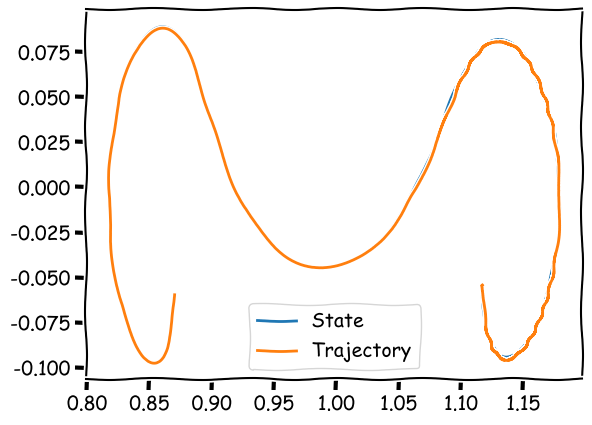

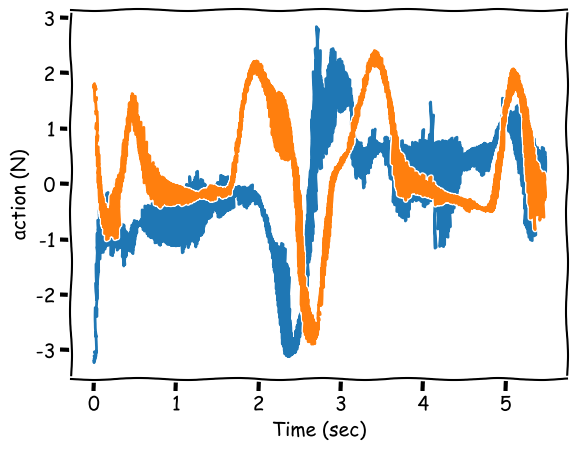

done 🥺
second player was in the game


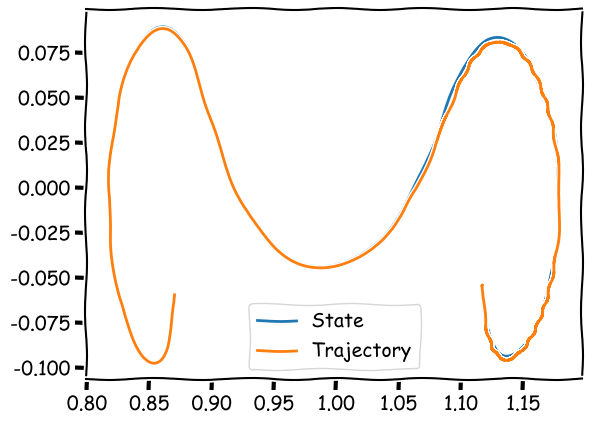

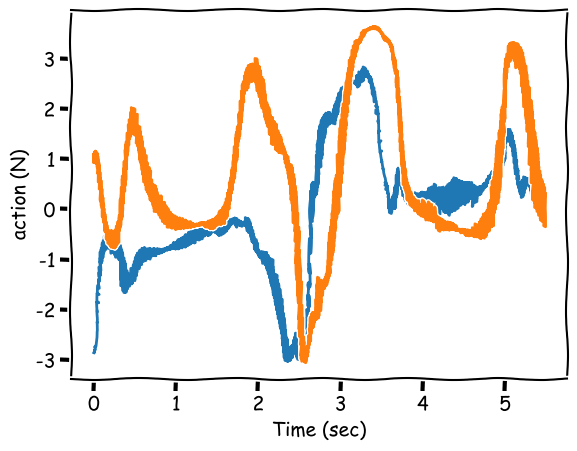

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(colorize(f"Device is {device}! 🥰😎", 'green', bold=True))
# Define variables directly
env = ThreeBodyEnv(trajectory)
hid = 64
l = 2
gamma = 0.99
seed = 0
epochs = 50
exp_name = 'sac'
steps_per_epoch_=30000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ac_kwargs = dict(hidden_sizes=[hid]*l)
states_array = []
# logger_kwargs = setup_logger_kwargs(exp_name, seed)
reward_array=[]

sac = SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)

zs_sac = ZS_SAC(lambda : ThreeBodyEnv(trajectory, error_range=0.01, final_range=0.001), epochs=100, device_class=device, ac_kwargs_class=ac_kwargs, steps_per_epoch=steps_per_epoch_, batch_size=1024, start_steps=5000, update_after=1000, update_every=2000)


zs_sac.load(filepath='model_zs/')
sac.load()


# test sac agent (not trained)
zs_sac.test(fun_mode=True, deterministic=True, save_data=False)
sac.test(fun_mode=True, deterministic=True, save_data=False)

# zs_sac.test(fun_mode=True)
zs_sac.env.second_player = False
sac.env.second_player = False

In [5]:
class PartialObservationWrapper(gym.Wrapper):
    """
    Gym environment wrapper that simulates partial observations (sensor loss) by masking parts of the state.
    This wrapper supports the Gymnasium API where:
      - reset returns: (observation, info)
      - step returns: (observation, reward, terminated, truncated, info)
    """

    def __init__(self, env, observation_mask_ratio=0.5):
        """
        Initializes the PartialObservationWrapper with a given masking ratio.
        - observation_mask_ratio: The percentage of state variables to mask (0 - 1).
        """
        super(PartialObservationWrapper, self).__init__(env)
        self.observation_mask_ratio = observation_mask_ratio  # Fraction of the state to mask (0-1)

    def reset(self, **kwargs):
        """
        Perturbs the observation by masking parts of it to simulate sensor loss.
        """
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            obs, info = result
        else:
            obs = result

        # Apply partial observation (sensor loss)
        obs = self._apply_sensor_loss(obs)

        return obs, info if isinstance(result, tuple) else obs

    def step(self, action):
        """
        Simulates sensor loss by modifying the observation returned from the environment.
        """
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Apply partial observation (sensor loss)
        obs = self._apply_sensor_loss(obs)

        return obs, reward, terminated, truncated, info

    def _apply_sensor_loss(self, observation):
        """
        Masks parts of the observation to simulate sensor loss.
        """
        observation = np.array(observation)

        # Create a mask for the observation. Randomly set the observation components to zero.
        mask = np.random.rand(*observation.shape) > self.observation_mask_ratio
        observation[mask] = 0  # Set the masked elements to zero to simulate missing data

        return observation


def make_env_partial_observation(error_range=0.01, final_range=0.001, observation_mask_ratio=0.5):
    """
    Creates the ThreeBodyEnv wrapped with partial observation (sensor loss).
    """
    env = ThreeBodyEnv(trajectory, error_range=error_range, final_range=final_range)
    return PartialObservationWrapper(env, observation_mask_ratio=observation_mask_ratio)


In [6]:
def run_episode(agent, env_fn, max_steps=10000):
    """
    Run one episode using the given agent and environment function.
    Adapted for Gymnasium (reset returns (obs, info) and step returns five outputs).

    Returns:
        total_reward: Sum of rewards collected in the episode.
    """
    env = env_fn()

    obs, _ = env.reset()  # Gymnasium reset returns (obs, info)
    total_reward = 0.0
    steps = 0
    done = False
    env.second_player = False

    while not done and steps < max_steps:
        # Assume the agent provides an 'act' method to select actions
        # action = agent.get_action(obs, 0)
        action = agent.ac.act(torch.as_tensor(obs, dtype=torch.float32, device=device), deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated  # Determine if the episode is done
        total_reward += reward
        steps += 1

    env.close()
    return total_reward


def evaluate_agent(agent, env_fn, num_episodes=20, max_steps=10000):
    """
    Evaluate the agent over multiple episodes and collect cumulative rewards.

    Returns:
        returns: List of cumulative rewards from each episode.
    """
    returns = []
    for i in range(num_episodes):
        ret = run_episode(agent, env_fn, max_steps)
        returns.append(ret)
        print(f"{i} of {num_episodes}")
    return returns


done 🥺
second player was in the game
0 of 10
done 🥺
second player was in the game
1 of 10
done 🥺
second player was in the game
2 of 10
done 🥺
second player was in the game
3 of 10
done 🥺
second player was in the game
4 of 10
done 🥺
second player was in the game
5 of 10
done 🥺
second player was in the game
6 of 10
done 🥺
second player was in the game
7 of 10
done 🥺
second player was in the game
8 of 10
done 🥺
second player was in the game
9 of 10
[-0.00684789  0.00733306 -0.02060042  0.01692698]
idx 0.09998 state 0.02848802193623475
too much error 🥲😱
second player was in the game
0 of 10
[-0.01000315 -0.00078349 -0.03858631  0.00725216]
idx 0.09979 state 0.04052374214672894
too much error 🥲😱
second player was in the game
1 of 10
[-0.00971211  0.00240989 -0.01919561  0.00619498]
idx 0.07916 state 0.022516257345347603
too much error 🥲😱
second player was in the game
2 of 10
[-0.00888136  0.00461564 -0.01739551  0.00560218]
idx 0.08257 state 0.02083676671130456
too much error 🥲😱
second play

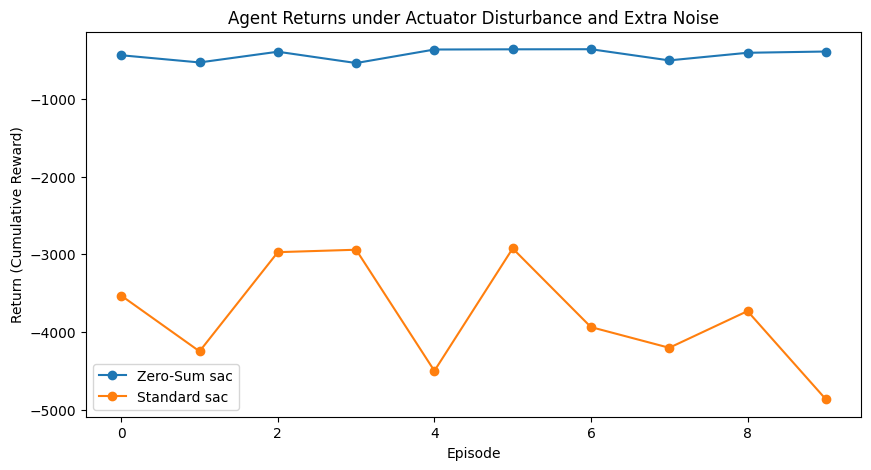

In [23]:
# Number of episodes for evaluation
num_episodes = 10

# Update the agents' environment function to use both actuator disturbance and extra noise
zs_sac.env_fn = lambda: make_env_partial_observation(observation_mask_ratio=.8)
sac.env_fn = lambda: make_env_partial_observation(observation_mask_ratio=.8)

# Evaluate Zero-Sum sac and Standard sac agents with actuator disturbance and extra noise
returns_zs_disturbance_noise = evaluate_agent(zs_sac, zs_sac.env_fn, num_episodes=num_episodes)
returns_std_disturbance_noise = evaluate_agent(sac, sac.env_fn, num_episodes=num_episodes)

# Calculate and print average returns
avg_return_zs_disturbance_noise = np.mean(returns_zs_disturbance_noise)
avg_return_std_disturbance_noise = np.mean(returns_std_disturbance_noise)

print("Zero-Sum sac with Actuator Disturbance and Extra Noise Average Return:", avg_return_zs_disturbance_noise)
print("Standard sac with Actuator Disturbance and Extra Noise Average Return:", avg_return_std_disturbance_noise)

# Plot the returns for visual comparison
plt.figure(figsize=(10, 5))
plt.plot(returns_zs_disturbance_noise, marker='o', label='Zero-Sum sac')
plt.plot(returns_std_disturbance_noise, marker='o', label='Standard sac')
plt.xlabel('Episode')
plt.ylabel('Return (Cumulative Reward)')
plt.title('Agent Returns under Actuator Disturbance and Extra Noise')
plt.legend()
plt.show()


/var/folders/cf/x6zpxdwn2dg40q0c0r418f7c0000gp/T/ipykernel_11366/2962769775.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Zero-Sum sac', 'Standard sac'])


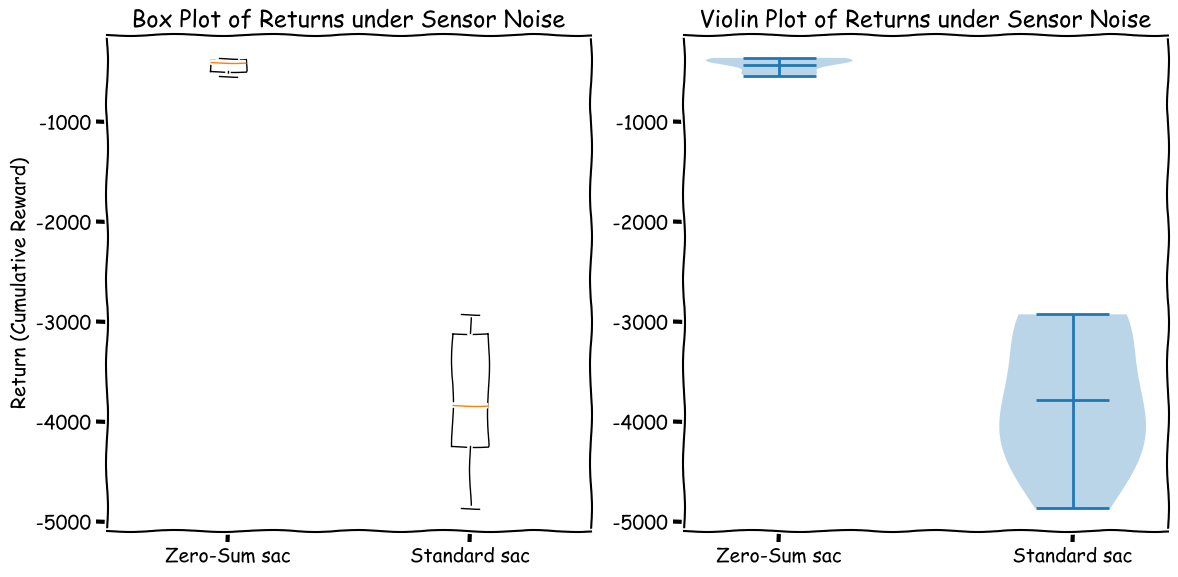

In [24]:
# Assume returns_zs and returns_std are lists of cumulative rewards from multiple episodes
data = [returns_zs_disturbance_noise, returns_std_disturbance_noise]
with plt.xkcd():
    # Create a figure with two subplots side-by-side
    plt.figure(figsize=(12, 6))

    # Box Plot
    plt.subplot(1, 2, 1)
    plt.boxplot(data, labels=['Zero-Sum sac', 'Standard sac'])
    plt.title('Box Plot of Returns under Sensor Noise')
    plt.ylabel('Return (Cumulative Reward)')

    # Violin Plot
    plt.subplot(1, 2, 2)
    plt.violinplot(data, showmeans=True)
    plt.xticks([1, 2], ['Zero-Sum sac', 'Standard sac'])
    plt.title('Violin Plot of Returns under Sensor Noise')

    plt.tight_layout()
    plt.show()


In [25]:
df  = pd.DataFrame(np.array(data).T, columns=['Zero-Sum sac', 'Standard sac'])
df.head()

,Zero-Sum sac,Standard sac
0,-434.426293,-3531.342776
1,-527.133928,-4249.189743
2,-389.002783,-2971.312830
3,-534.737731,-2940.112962
4,-360.546699,-4500.831147


In [26]:
# save csv
df.to_csv('evaluation_returns.csv', index=False)
